In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os

In [25]:
# Connect to the Pgsql database
conn = psycopg2.connect(
    host='localhost',
    user='postgres',
    password='sql',
    database='EcommerceDB'
)
cursor = conn.cursor()

# Basic Queries

## 1. List all unique cities where customers are located.

In [3]:
query = ''' 
SELECT DISTINCT
	CUSTOMER_CITY
FROM
	CUSTOMERS
 '''
 
cursor.execute(query)

d1 = cursor.fetchall()
df = pd.DataFrame(d1)
df.head(10)

,0
0,bom jardim de minas
1,alto rio doce
2,alvorada do gurgueia
3,batatais
4,capao da porteira
5,icatu
6,osorio
7,populina
8,novo mundo
9,tururu


## 2. Count the number of orders placed in 2017.


In [4]:
query = ''' 
SELECT COUNT(order_id)
FROM orders
WHERE EXTRACT(YEAR FROM order_purchase_timestamp) = 2017;

'''
 
cursor.execute(query)

d2 = cursor.fetchall()
print('Total number of orders is :', d2[0][0])


Total number of orders is : 45101


## 3. Find the total sales per category.


In [5]:
query = ''' 
SELECT
	UPPER(PRODUCTS.PRODUCT_CATEGORY),
	SUM(PAYMENTS.PAYMENT_VALUE) SALES
FROM
	PUBLIC.PRODUCTS
	JOIN PUBLIC.ORDER_ITEMS ON PUBLIC.PRODUCTS.PRODUCT_ID = PUBLIC.ORDER_ITEMS.PRODUCT_ID
	JOIN PUBLIC.PAYMENTS ON PUBLIC.PAYMENTS.ORDER_ID = PUBLIC.ORDER_ITEMS.ORDER_ID
GROUP BY
	PRODUCT_CATEGORY
'''
 
cursor.execute(query)

d3 = cursor.fetchall()
d3 = pd.DataFrame(d3, columns=['Category', 'Orders'])
d3

,Category,Orders
0,AGRO INDUSTRIA E COMERCIO,118730.61
1,ART,30992.93
2,ARTS AND CRAFTS,2326.17
3,AUDIO,60324.62
4,AUTOMOTIVE,852294.33
...,...,...
69,TECHNICAL BOOKS,24915.44
70,TELEPHONY,486882.05
71,TOYS,619037.69
72,WATCHES PRESENT,1429216.68


## 4. Calculate the percentage of orders that were paid in installments.


In [6]:
query = ''' 

SELECT
	ROUND(
		100.0 * SUM(
			CASE
				WHEN PAYMENT_INSTALLMENTS >= 1 THEN 1
				ELSE 0
			END
		) / COUNT(*),
		4
	) AS PERCENTAGE_PAID
FROM
	PAYMENTS
'''
 
cursor.execute(query)

k1 = cursor.fetchall()
print('The % of orders that were paid in installments', k1[0][0])


The % of orders that were paid in installments 99.9981


## 5. Count the number of customers from each state. 


In [9]:
query = ''' 
SELECT
    CUSTOMER_STATE,
    COUNT(CUSTOMER_ID) AS NUM
FROM
    PUBLIC.CUSTOMERS
GROUP BY
    CUSTOMER_STATE
ORDER BY
    NUM DESC
'''
 
cursor.execute(query)

data = cursor.fetchall()
d = pd.DataFrame(data, columns = ["state", "customer_count" ])
d


,state,customer_count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


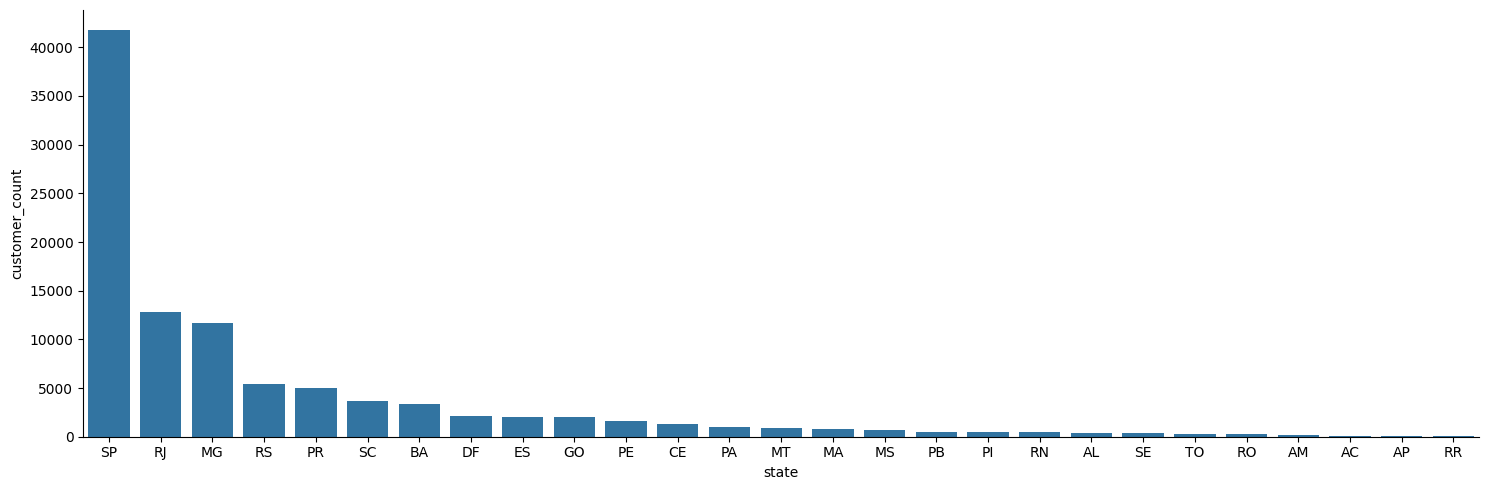

In [10]:
sns.catplot(
    data=d,
    kind='bar',
    x='state',
    y='customer_count',
    aspect=3,
    
)
plt.show()

# Intermediate Queries


## 1. Calculate the number of orders per month in 2018.


In [11]:
query = ''' 
SELECT 
  TO_CHAR(order_purchase_timestamp, 'Month') AS month_name,
  COUNT(order_id) AS order_count
FROM 
  orders  
WHERE
  EXTRACT(YEAR FROM order_purchase_timestamp) = 2018
GROUP BY
  month_name
'''
 
cursor.execute(query)

k = pd.DataFrame(cursor.fetchall(), columns=['Month', 'Sales'])
k


,Month,Sales
0,April,6939
1,August,6512
2,February,6728
3,January,7269
4,July,6292
5,June,6167
6,March,7211
7,May,6873
8,October,4
9,September,16


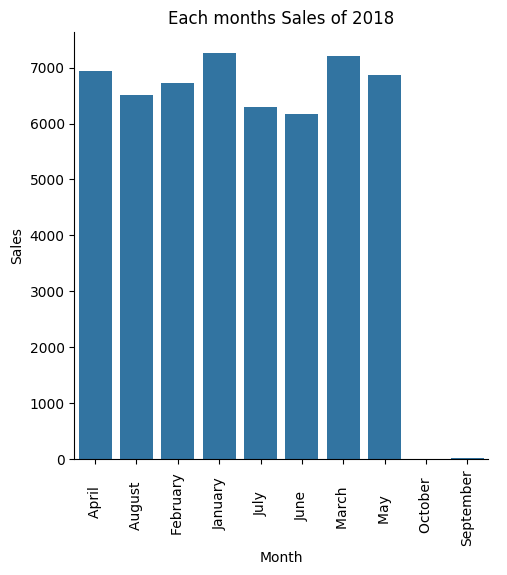

In [13]:
sns.catplot(
  data=k,
  kind='bar',
  x='Month',
  y='Sales'    
)
plt.title('Each months Sales of 2018')
plt.xticks(rotation=90)
plt.show()

## 2. Find the average number of products per order, grouped by customer city.


In [14]:
query = ''' 
WITH
	COUNT_PER_ORDER AS (
		SELECT
			PUBLIC.ORDERS.ORDER_ID,
			PUBLIC.ORDERS.CUSTOMER_ID,
			COUNT(ORDER_ITEMS.ORDER_ID) AS OC
		FROM
			PUBLIC.ORDERS
			JOIN PUBLIC.ORDER_ITEMS ON PUBLIC.ORDERS.ORDER_ID = PUBLIC.ORDER_ITEMS.ORDER_ID
		GROUP BY
			PUBLIC.ORDERS.ORDER_ID,
			PUBLIC.ORDERS.CUSTOMER_ID
	)
SELECT
	PUBLIC.CUSTOMERS.CUSTOMER_CITY,
	ROUND(AVG(COUNT_PER_ORDER.OC), 2) AS AVG_ORDER_COUNT
FROM
	PUBLIC.CUSTOMERS
	JOIN COUNT_PER_ORDER ON PUBLIC.CUSTOMERS.CUSTOMER_ID = COUNT_PER_ORDER.CUSTOMER_ID
GROUP BY
	PUBLIC.CUSTOMERS.CUSTOMER_CITY
ORDER BY
	AVG_ORDER_COUNT DESC;
'''
 
cursor.execute(query)

g = pd.DataFrame(cursor.fetchall() , columns=['City', 'Order'])
g

,City,Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sao joao evangelista,1.00
4106,araponga,1.00
4107,arraias,1.00
4108,zacarias,1.00


## 3. Calculate the percentage of total revenue contributed by each product category.


In [15]:
query = ''' 
SELECT
	UPPER(PUBLIC.PRODUCTS.PRODUCT_CATEGORY),
	(SUM(PUBLIC.ORDER_ITEMS.PRICE) / 
        (select sum(public.payments.payment_value) 
                    from public.payments) ) *100 
        AS TOTAL_PRICE
FROM
	PUBLIC.PRODUCTS
	INNER JOIN PUBLIC.ORDER_ITEMS 
 ON PUBLIC.PRODUCTS.PRODUCT_ID = PUBLIC.ORDER_ITEMS.PRODUCT_ID
GROUP BY
	PUBLIC.PRODUCTS.PRODUCT_CATEGORY
ORDER BY
	TOTAL_PRICE DESC
'''
 
cursor.execute(query)

g = pd.DataFrame(cursor.fetchall() , columns=['Category', '%Revenue'])
g.head(15)

,Category,%Revenue
0,HEALTH BEAUTY,7.862399
1,WATCHES PRESENT,7.527112
2,BED TABLE BATH,6.477587
3,SPORT LEISURE,6.171884
4,COMPUTER ACCESSORIES,5.696556
5,FURNITURE DECORATION,4.558488
6,COOL STUFF,3.968367
7,HOUSEWARES,3.949364
8,AUTOMOTIVE,3.702448
9,GARDEN TOOLS,3.031172


## 4. Identify the correlation between product price and the number of times a product has been purchased.


In [16]:
query = ''' 
SELECT
	PRODUCTS.PRODUCT_CATEGORY,
	COUNT(ORDER_ITEMS.PRODUCT_ID),
	ROUND(AVG(ORDER_ITEMS.PRICE)::numeric, 2)
FROM
	PRODUCTS
	JOIN ORDER_ITEMS ON PRODUCTS.PRODUCT_ID = ORDER_ITEMS.PRODUCT_ID
GROUP BY
	PRODUCTS.PRODUCT_CATEGORY
'''
 
cursor.execute(query)
data = cursor.fetchall()
g9 = pd.DataFrame(data,columns = ["Category", "order_count","price"])
g9.head(15)

,Category,order_count,price
0,Agro Industria e Comercio,212,342.12
1,Art,209,115.80
2,Arts and Crafts,24,75.58
3,audio,364,139.25
4,automotive,4235,139.96
5,babies,3065,134.34
6,Bags Accessories,1092,128.60
7,bed table bath,11115,93.30
8,Blu Ray DVDs,64,93.74
9,Casa Construcao,604,137.56


In [17]:
# Check for NaN values and drop them
arr1 = g9["order_count"].dropna().values
arr2 = g9["price"].dropna().values

# # Convert to numeric in case of unexpected types (optional)
arr1 = pd.to_numeric(arr1, errors='coerce')
arr2 = pd.to_numeric(arr2, errors='coerce')

# # Ensure both arrays have the same length after dropping NaNs
min_length = min(len(arr1), len(arr2))
arr1 = arr1[:min_length]
arr2 = arr2[:min_length]

# Calculate the correlation coefficient matrix
a = np.corrcoef(arr1, arr2)

# Print the correlation between arr1 and arr2
print("The correlation is", a[0, 1])


The correlation is -0.106316258238607


## 5. Calculate the total revenue generated by each seller, and rank them by revenue.


In [18]:
query = ''' 
SELECT
	ORDER_ITEMS.SELLER_ID,
	SUM(PAYMENTS.PAYMENT_VALUE) AS REVENUE,
	DENSE_RANK() OVER (
		ORDER BY
			SUM(PAYMENTS.PAYMENT_VALUE) DESC
	) AS REVENUE_RANK
FROM
	ORDER_ITEMS
	JOIN PAYMENTS 
    ON ORDER_ITEMS.ORDER_ID = PAYMENTS.ORDER_ID
GROUP BY
	ORDER_ITEMS.SELLER_ID
ORDER BY
	REVENUE DESC;
'''
 
cursor.execute(query)

gg = pd.DataFrame(cursor.fetchall() , columns=['Seller', 'Revenue', 'Rank'])
gg.head(15)

,Seller,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


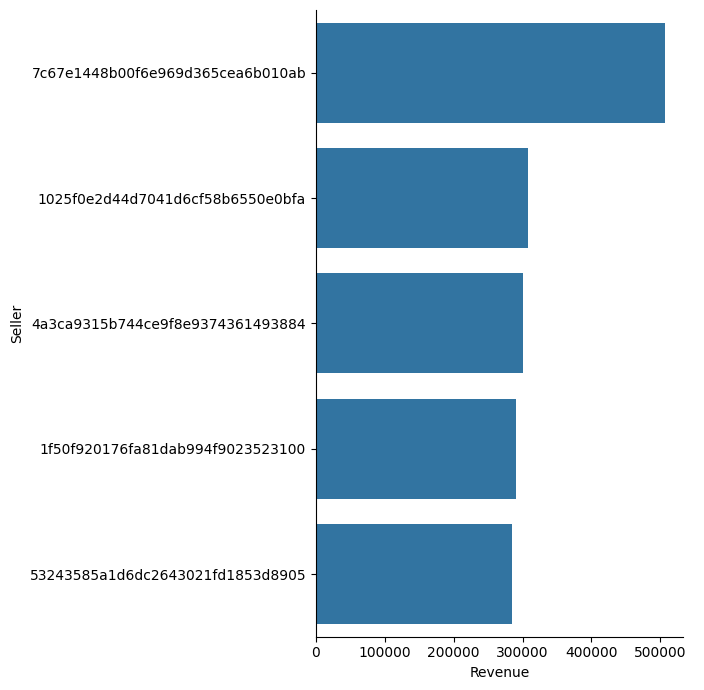

In [19]:
sns.catplot(
    data=gg.head(5),
    kind='bar',
    x='Revenue',
    y='Seller',
    height=7,
    
    
)
plt.show()

# Advanced Queries

## 1. Calculate the moving average of order values for each customer over their order history.


In [20]:
query = ''' 
SELECT
	CUSTOMER_ID,
	ORDER_PURCHASE_TIMESTAMP,
	PAYMENT,
	AVG(PAYMENT) OVER (
		PARTITION BY
			CUSTOMER_ID
		ORDER BY
			ORDER_PURCHASE_TIMESTAMP ROWS BETWEEN 2 PRECEDING
			AND CURRENT ROW
	) AS MOVING_AVG
FROM
	(
		SELECT
			PUBLIC.ORDERS.CUSTOMER_ID,
			PUBLIC.ORDERS.ORDER_PURCHASE_TIMESTAMP,
			PUBLIC.PAYMENTS.PAYMENT_VALUE AS PAYMENT
		FROM
			PUBLIC.PAYMENTS
			JOIN PUBLIC.ORDERS ON PUBLIC.PAYMENTS.ORDER_ID = PUBLIC.ORDERS.ORDER_ID
	) AS A
 ORDER BY 
	MOVING_AVG DESC
'''
 
cursor.execute(query)

g = pd.DataFrame(cursor.fetchall() , columns=['customerID', 'Date','Payment', 'Moving_avg'])
g.head(15)

,customerID,Date,Payment,Moving_avg
0,1617b1357756262bfa56ab541c47bc16,2017-09-29 15:24:52,13664.08,13664.08
1,ec5b2ba62e574342386871631fafd3fc,2018-07-15 14:49:44,7274.88,7274.88
2,c6e2731c5b391845f6800c97401a43a9,2017-02-12 20:37:36,6929.31,6929.31
3,f48d464a0baaea338cb25f816991ab1f,2018-07-25 18:10:17,6922.21,6922.21
4,3fd6777bbce08a352fddd04e4a7cc8f6,2017-05-24 18:14:34,6726.66,6726.66
5,05455dfa7cd02f13d132aa7a6a9729c6,2017-11-24 11:03:35,6081.54,6081.54
6,df55c14d1476a9a3467f131269c2477f,2017-04-01 15:58:40,4950.34,4950.34
7,e0a2412720e9ea4f26c1ac985f6a7358,2018-07-12 12:08:36,4809.44,4809.44
8,24bbf5fd2f2e1b359ee7de94defc4a15,2017-04-18 18:50:13,4764.34,4764.34
9,3d979689f636322c62418b6346b1c6d2,2018-06-22 12:23:19,4681.78,4681.78


## 2. Calculate the cumulative sales per month for each year.


In [21]:
query = ''' 
SELECT
	YEARS,	MONTHS,	PAYMENT,
	SUM(PAYMENT) OVER (ORDER BY(YEARS, MONTHS)) CUMULATIVE_SALES

FROM(
SELECT
    EXTRACT(YEAR FROM PUBLIC.ORDERS.ORDER_PURCHASE_TIMESTAMP) AS YEARS,
    EXTRACT(MONTH FROM PUBLIC.ORDERS.ORDER_PURCHASE_TIMESTAMP) AS MONTHS,
    ROUND(SUM(PUBLIC.PAYMENTS.PAYMENT_VALUE)::NUMERIC, 2) AS PAYMENT
FROM
    PUBLIC.ORDERS
    JOIN PUBLIC.PAYMENTS ON PUBLIC.PAYMENTS.ORDER_ID = PUBLIC.ORDERS.ORDER_ID
GROUP BY
    1,
    2
ORDER BY
    1,
    2);

'''
 
cursor.execute(query)


g = pd.DataFrame(cursor.fetchall() , columns=['Year', 'Month','Payment', 'CUMULATIVE_SALES'])
g.head(15)

,Year,Month,Payment,CUMULATIVE_SALES
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


## 3. Calculate the year-over-year growth rate of total sales.


In [22]:
query = ''' 
WITH YEAR_PAY AS (
  SELECT
    EXTRACT(YEAR FROM PUBLIC.ORDERS.ORDER_PURCHASE_TIMESTAMP) AS YEARS,
    ROUND(SUM(PUBLIC.PAYMENTS.PAYMENT_VALUE)::NUMERIC, 2) AS PAYMENT
  FROM
    PUBLIC.ORDERS
  JOIN PUBLIC.PAYMENTS ON PUBLIC.PAYMENTS.ORDER_ID = PUBLIC.ORDERS.ORDER_ID
  GROUP BY 1
)
SELECT
  YEARS,
  ROUND(
    (
      (PAYMENT - LAG(PAYMENT, 1) OVER (ORDER BY YEARS)) / 
      LAG(PAYMENT, 1) OVER (ORDER BY YEARS)
    ) * 100,
    2
  ) AS YOY_GROWTH
FROM
  YEAR_PAY
ORDER BY
  YEARS;
'''
 
cursor.execute(query)

pd.DataFrame(cursor.fetchall(), columns=['Year', 'YoY'])

,Year,YoY
0,2016,None
1,2017,12112.70
2,2018,20.00


## 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [23]:
query = ''' 
WITH 
	FIRST_PURCHASE_DATE AS (
		SELECT 
			C.customer_id,
			MIN(order_purchase_timestamp) AS FIRST_TIME_PURCHASE
		FROM
			public.customers C
			JOIN public.orders O ON C.customer_id = O.customer_id
		GROUP BY 
			C.customer_id
		),


	NEXT_PURCHASE_DATE AS (
		SELECT 
			FPD.customer_id,
			COUNT(DISTINCT(O.order_purchase_timestamp)) AS NEXT_TIME_PURCHASE
		FROM
			FIRST_PURCHASE_DATE FPD
			JOIN public.orders O ON O.customer_id = FPD.customer_id
			AND O.order_purchase_timestamp > FIRST_TIME_PURCHASE
			AND O.order_purchase_timestamp < FPD.FIRST_TIME_PURCHASE + INTERVAL '6 MONTH'
		GROUP BY
			FPD.customer_id
		)

SELECT 
	100 * ( COUNT(DISTINCT FPD.customer_id) / COUNT(DISTINCT NPD.customer_id)) AS REPEATED_PURCHASE
FROM
	FIRST_PURCHASE_DATE FPD 
	LEFT JOIN NEXT_PURCHASE_DATE NPD
	ON FPD.customer_id = NPD.customer_id
WHERE 
    NPD.customer_id IS NOT NULL;	


'''
 
cursor.execute(query)

cursor.fetchall()

DivisionByZero: division by zero


### ZERO CUSTOMERS RETENTION RATES

## 5. Identify the top 3 customers who spent the most money in each year.


In [26]:
query = ''' 
SELECT * 
FROM (
	SELECT 
		O.customer_id,
		SUM(P.payment_value) AS AMOUNT_SPEND,
		EXTRACT(YEAR FROM (O.order_purchase_timestamp)) YEARS,
		DENSE_RANK() OVER(PARTITION BY EXTRACT(YEAR FROM (O.order_purchase_timestamp)) ORDER BY SUM(P.payment_value)DESC) RANKING
	FROM 
		public.orders O 
		JOIN public.payments P ON P.order_id = O.order_id
	GROUP BY 
		O.customer_id,
		 EXTRACT(YEAR FROM (O.order_purchase_timestamp))
	)
WHERE
	RANKING <=3
'''
 
cursor.execute(query)

g1 = pd.DataFrame(cursor.fetchall() , columns=['CustomerID', 'Amount_spend','Year', 'Rank'])
g1.head(15)

,CustomerID,Amount_spend,Year,Rank
0,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,2016,1
1,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2016,2
2,4a06381959b6670756de02e07b83815f,1227.78,2016,3
3,1617b1357756262bfa56ab541c47bc16,13664.08,2017,1
4,c6e2731c5b391845f6800c97401a43a9,6929.31,2017,2
5,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,2017,3
6,ec5b2ba62e574342386871631fafd3fc,7274.88,2018,1
7,f48d464a0baaea338cb25f816991ab1f,6922.21,2018,2
8,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,2018,3


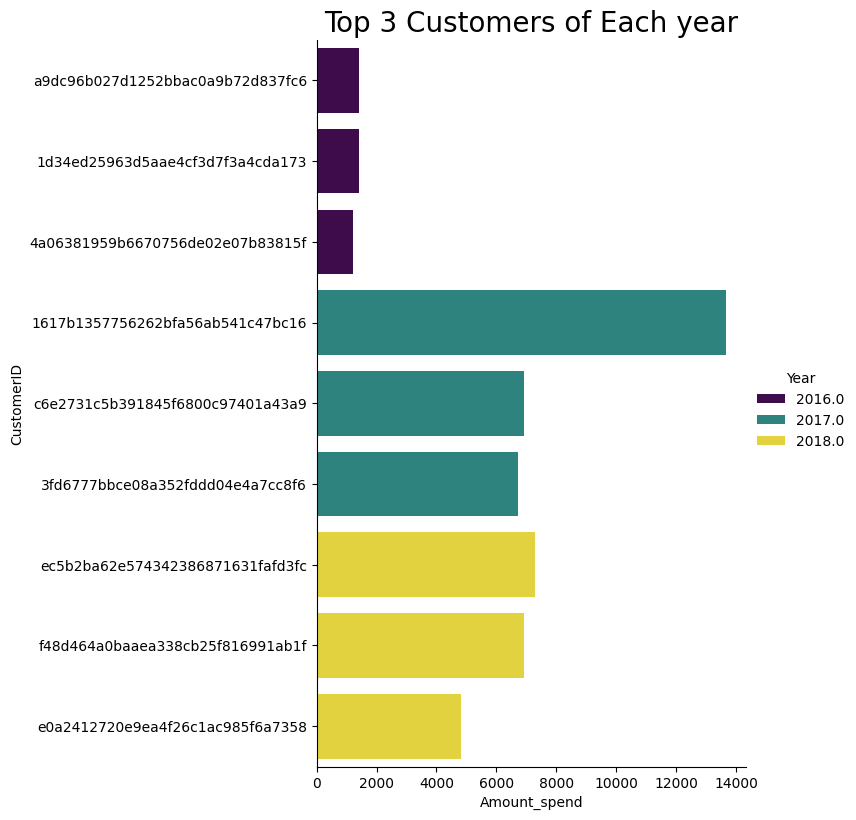

In [27]:

sns.catplot(
    data=g1,
    kind='bar',
    y='CustomerID',
    x='Amount_spend',
    hue='Year',
    height=8,
    palette='viridis',
    
)

plt.title('Top 3 Customers of Each year', size=20)
plt.show()